In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('final_dataset.csv')

In [3]:
df.head()

,date,AQI_calculated
0,2020-11-25 16:00:00,480.0
1,2020-11-25 17:00:00,482.0
2,2020-11-25 18:00:00,482.0
3,2020-11-25 19:00:00,481.0
4,2020-11-25 20:00:00,479.0


<Axes: xlabel='AQI_calculated', ylabel='Count'>

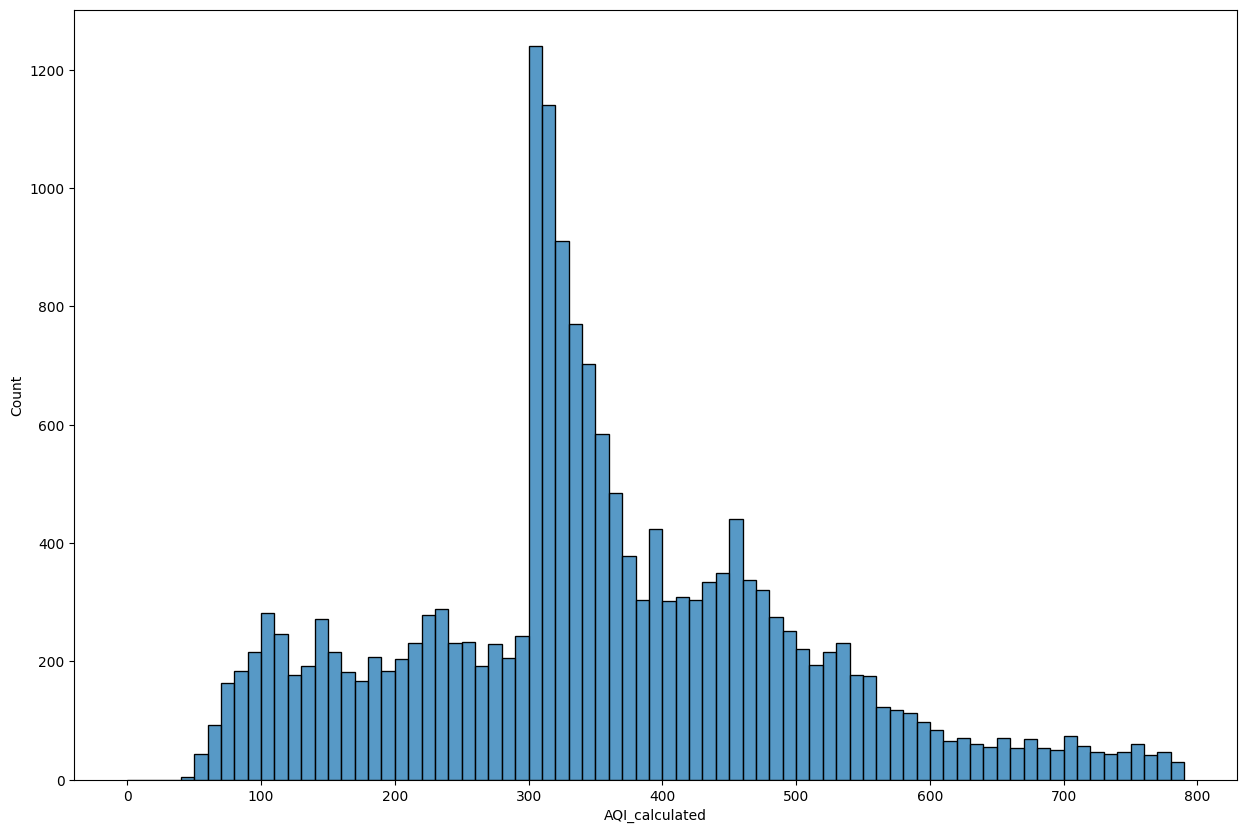

In [4]:
plt.figure(figsize=(15,10))
sns.histplot(df.AQI_calculated,bins = [i for i in range(0,800,10)])

In [5]:
df1=df.reset_index()['AQI_calculated']

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
df1

array([[0.28571429],
       [0.2870249 ],
       [0.2870249 ],
       ...,
       [0.3440367 ],
       [0.34469201],
       [0.34469201]])

In [8]:
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
training_size,test_size

(15162, 3791)

In [10]:
train_data

array([[0.28571429],
       [0.2870249 ],
       [0.2870249 ],
       ...,
       [0.05307995],
       [0.05307995],
       [0.05307995]])

In [11]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
time_step = 250
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(250,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

233/233 [==============================] - 44s 170ms/step - loss: 0.0028 - val_loss: 6.8941e-04
Epoch 2/100
233/233 [==============================] - 39s 169ms/step - loss: 5.7945e-04 - val_loss: 2.7843e-04
Epoch 3/100
233/233 [==============================] - 41s 175ms/step - loss: 3.1129e-04 - val_loss: 1.3448e-04
Epoch 4/100
233/233 [==============================] - 40s 171ms/step - loss: 2.0748e-04 - val_loss: 1.7127e-04
Epoch 5/100
233/233 [==============================] - 39s 168ms/step - loss: 1.5086e-04 - val_loss: 7.1681e-05
Epoch 6/100
233/233 [==============================] - 39s 168ms/step - loss: 1.2898e-04 - val_loss: 3.9312e-05
Epoch 7/100
233/233 [==============================] - 39s 168ms/step - loss: 1.0079e-04 - val_loss: 1.2548e-04
Epoch 8/100
233/233 [==============================] - 39s 168ms/step - loss: 8.0711e-05 - val_loss: 3.6671e-05
Epoch 9/100
233/233 [==============================] - 42s 182ms/step - loss: 7.6285e-05 - val_loss: 4.6422

In [17]:
import tensorflow as tf

In [18]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

111/111 [==============================] - 4s 35ms/step


In [19]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [20]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

420.28780674598937

In [21]:
math.sqrt(mean_squared_error(ytest,test_predict))

455.7785884800012

In [22]:
len(test_data)

3791

In [26]:
x_input=test_data[3541:].reshape(1,-1)
x_input.shape

(1, 250)

In [27]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [28]:
lst_output=[]
n_steps=250
i=0
while(i<24):
    
    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} hour input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} hour output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.34246507]
251
1 hour input [0.43250328 0.43250328 0.43184797 0.43184797 0.43053735 0.43053735
 0.43184797 0.43315858 0.4344692  0.43577982 0.43512451 0.42922674
 0.4180865  0.39973788 0.3768021  0.3604194  0.34141547 0.3197903
 0.29750983 0.27457405 0.25163827 0.23001311 0.2214941  0.21625164
 0.2129751  0.21035387 0.20707733 0.20445609 0.20117955 0.19855832
 0.19593709 0.19200524 0.1887287  0.18479685 0.18152031 0.17889908
 0.17693316 0.17627785 0.17562254 0.17627785 0.17627785 0.17627785
 0.17627785 0.17562254 0.17431193 0.17300131 0.172346   0.17169069
 0.17103539 0.17169069 0.17300131 0.17496723 0.17758847 0.1802097
 0.18348624 0.18479685 0.18479685 0.18545216 0.18545216 0.18676278
 0.18807339 0.18938401 0.19069463 0.19200524 0.19266055 0.19397117
 0.19462647 0.19528178 0.19528178 0.19593709 0.19593709 0.19593709
 0.19593709 0.19593709 0.19593709 0.19528178 0.19528178 0.19462647
 0.19462647 0.19528178 0.1965924  0.19724771 0.19790301 0.19921363
 0.19986894 0.20052425 0.20249017 

In [29]:
hour_new=np.arange(1,251)
hour_pred=np.arange(251,275)

In [30]:
len(df1)

18953

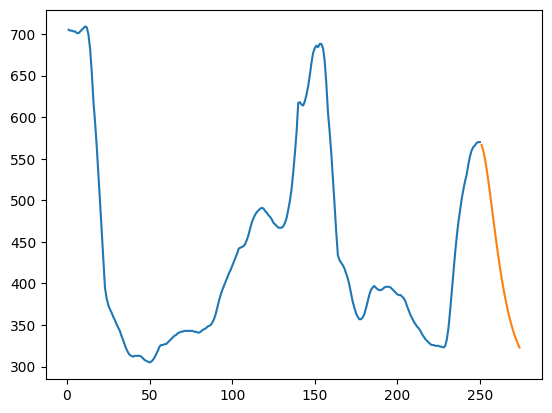

In [32]:
plt.plot(hour_new,scaler.inverse_transform(df1[18703:]))
plt.plot(hour_pred,scaler.inverse_transform(lst_output))

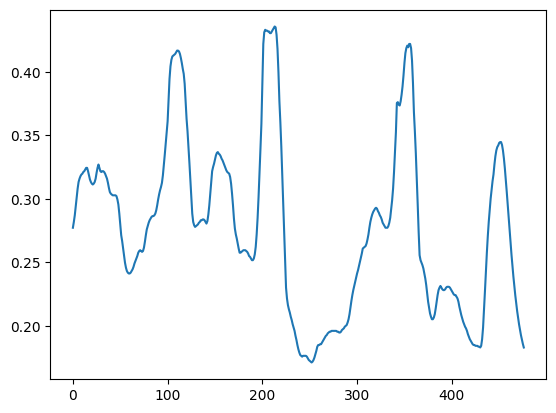

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[18500:])

In [34]:
df3=scaler.inverse_transform(df3).tolist()

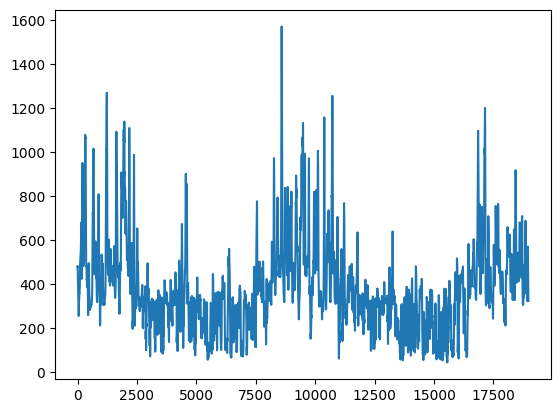

In [35]:
plt.plot(df3)

In [36]:
len(df3)

18977

In [37]:
df4 = pd.DataFrame(df3)

# Print the DataFrame
print(df4)

                0
0      480.000000
1      482.000000
2      482.000000
3      481.000000
4      479.000000
...           ...
18972  343.936227
18973  337.788237
18974  332.283902
18975  327.375607
18976  323.011550

[18977 rows x 1 columns]


In [ ]:
df.tail(20)

,date,AQI_calculated
18741,2023-01-23 13:00:00,347.0
18742,2023-01-23 14:00:00,368.0
18743,2023-01-23 15:00:00,391.0
18744,2023-01-23 16:00:00,415.0
18745,2023-01-23 17:00:00,437.0
18746,2023-01-23 18:00:00,457.0
18747,2023-01-23 19:00:00,474.0
18748,2023-01-23 20:00:00,488.0
18749,2023-01-23 21:00:00,502.0
18750,2023-01-23 22:00:00,513.0


In [40]:
df4[0].tail(24)

18953    566.601701
18954    559.893100
18955    550.330550
18956    538.417998
18957    524.830161
18958    510.135698
18959    494.822776
18960    479.301836
18961    463.919150
18962    448.958048
18963    434.634280
18964    421.095286
18965    408.425611
18966    396.658953
18967    385.794086
18968    375.808315
18969    366.668123
18970    358.335626
18971    350.771668
18972    343.936227
18973    337.788237
18974    332.283902
18975    327.375607
18976    323.011550
Name: 0, dtype: float64